# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean (вычитам среднее)
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в этой функции.
Вычислите градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)


In [4]:
# TODO: Implement gradient check function
def sqr(x):
    return x*x, 2*x

check_gradient(sqr, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [5]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

probs = linear_classifer.softmax(np.array([[-10, 0, 10],[10, 0, -10]]))

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [6]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
print("probs = ", probs)
h = linear_classifer.cross_entropy_loss(probs, 2) 
print("h = ", h)

probs = linear_classifer.softmax(np.array([[-5, 0, 5],[5, 0, -5]]))
print("probs = ", probs)
h = linear_classifer.cross_entropy_loss(probs, np.array([[0],[1]]))
print("h = ", h)

probs =  [4.50940412e-05 6.69254912e-03 9.93262357e-01]
h =  0.0022534811823737236
probs =  [[4.50940412e-05 6.69254912e-03 9.93262357e-01]
 [9.93262357e-01 6.69254912e-03 4.50940412e-05]]
h =  7.506760443547121


После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [7]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
print(loss)
print(grad)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

0.5171482379773503
[ 0.19203896 -0.26268615  0.07064719]
Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [8]:
# TODO Extend combined function so it can receive a 2d array with batch of samples

# Test batch_size = 1
batch_size = 1
predictions = np.zeros((batch_size, 3))
target_index = np.ones(batch_size, np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
batch_size = 3
predictions = np.zeros((batch_size, 3))
target_index = np.ones(batch_size, np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

Gradient check passed!
Gradient check passed!


True

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [9]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [10]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [18]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

	Epoch 0, loss: 2.397148
	Epoch 1, loss: 2.330656
	Epoch 2, loss: 2.310399
	Epoch 3, loss: 2.304705
	Epoch 4, loss: 2.302612
	Epoch 5, loss: 2.302263
	Epoch 6, loss: 2.301943
	Epoch 7, loss: 2.301907
	Epoch 8, loss: 2.302160
	Epoch 9, loss: 2.302092


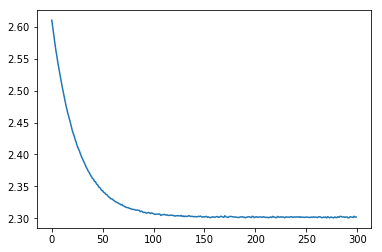

In [19]:
# let's look at the loss history!
plt.plot(loss_history)

In [ ]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [20]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = 0
best_pair_hyper = None

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially
i = 0
for lr in learning_rates:
    for rs in reg_strengths:
        i+=1
        if i < 5:
            print("break!")
            continue
        loss = classifier.fit(train_X, train_y, epochs=num_epochs, learning_rate=lr, batch_size=batch_size, reg=rs)
        pred = classifier.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)
        print("Accuracy after training for " ,num_epochs, " epochs: ", accuracy, " lr = ", lr, " rs = ", rs)
        if accuracy > best_val_accuracy:
            best_val_accuracy = accuracy
            best_classifier = classifier
            best_pair_hyper = (lr, rs)

print('best validation accuracy achieved: %f' % best_val_accuracy)

break!
break!
break!
break!
	Epoch 0, loss: 2.301138
	Epoch 1, loss: 2.300471
	Epoch 2, loss: 2.300921
	Epoch 3, loss: 2.301452
	Epoch 4, loss: 2.300573
	Epoch 5, loss: 2.300664
	Epoch 6, loss: 2.299392
	Epoch 7, loss: 2.300232
	Epoch 8, loss: 2.299526
	Epoch 9, loss: 2.300008
	Epoch 10, loss: 2.301083
	Epoch 11, loss: 2.298439
	Epoch 12, loss: 2.298380
	Epoch 13, loss: 2.298071
	Epoch 14, loss: 2.301033
	Epoch 15, loss: 2.299461
	Epoch 16, loss: 2.299454
	Epoch 17, loss: 2.299190
	Epoch 18, loss: 2.300550
	Epoch 19, loss: 2.296384
	Epoch 20, loss: 2.298674
	Epoch 21, loss: 2.299364
	Epoch 22, loss: 2.298177
	Epoch 23, loss: 2.299317
	Epoch 24, loss: 2.297611
	Epoch 25, loss: 2.298694
	Epoch 26, loss: 2.300977
	Epoch 27, loss: 2.298772
	Epoch 28, loss: 2.296161
	Epoch 29, loss: 2.300098
	Epoch 30, loss: 2.299087
	Epoch 31, loss: 2.300797
	Epoch 32, loss: 2.296854
	Epoch 33, loss: 2.300525
	Epoch 34, loss: 2.295961
	Epoch 35, loss: 2.297087
	Epoch 36, loss: 2.296914
	Epoch 37, loss: 2.2

	Epoch 108, loss: 2.274409
	Epoch 109, loss: 2.287344
	Epoch 110, loss: 2.280552
	Epoch 111, loss: 2.280583
	Epoch 112, loss: 2.275654
	Epoch 113, loss: 2.278763
	Epoch 114, loss: 2.275843
	Epoch 115, loss: 2.275853
	Epoch 116, loss: 2.279920
	Epoch 117, loss: 2.275494
	Epoch 118, loss: 2.273438
	Epoch 119, loss: 2.271109
	Epoch 120, loss: 2.283515
	Epoch 121, loss: 2.273274
	Epoch 122, loss: 2.270946
	Epoch 123, loss: 2.281297
	Epoch 124, loss: 2.275136
	Epoch 125, loss: 2.277544
	Epoch 126, loss: 2.273429
	Epoch 127, loss: 2.277598
	Epoch 128, loss: 2.278414
	Epoch 129, loss: 2.275057
	Epoch 130, loss: 2.273428
	Epoch 131, loss: 2.277545
	Epoch 132, loss: 2.271270
	Epoch 133, loss: 2.273426
	Epoch 134, loss: 2.285074
	Epoch 135, loss: 2.268210
	Epoch 136, loss: 2.276095
	Epoch 137, loss: 2.275181
	Epoch 138, loss: 2.275574
	Epoch 139, loss: 2.285479
	Epoch 140, loss: 2.274534
	Epoch 141, loss: 2.271005
	Epoch 142, loss: 2.283361
	Epoch 143, loss: 2.269772
	Epoch 144, loss: 2.275534
	

	Epoch 11, loss: 2.265255
	Epoch 12, loss: 2.261833
	Epoch 13, loss: 2.267040
	Epoch 14, loss: 2.274038
	Epoch 15, loss: 2.260103
	Epoch 16, loss: 2.266232
	Epoch 17, loss: 2.272348
	Epoch 18, loss: 2.271739
	Epoch 19, loss: 2.270591
	Epoch 20, loss: 2.272882
	Epoch 21, loss: 2.260872
	Epoch 22, loss: 2.261465
	Epoch 23, loss: 2.277912
	Epoch 24, loss: 2.268041
	Epoch 25, loss: 2.264876
	Epoch 26, loss: 2.270447
	Epoch 27, loss: 2.273579
	Epoch 28, loss: 2.272618
	Epoch 29, loss: 2.268711
	Epoch 30, loss: 2.279359
	Epoch 31, loss: 2.262793
	Epoch 32, loss: 2.264469
	Epoch 33, loss: 2.255006
	Epoch 34, loss: 2.280238
	Epoch 35, loss: 2.264968
	Epoch 36, loss: 2.270547
	Epoch 37, loss: 2.276229
	Epoch 38, loss: 2.263994
	Epoch 39, loss: 2.275998
	Epoch 40, loss: 2.263161
	Epoch 41, loss: 2.268643
	Epoch 42, loss: 2.266088
	Epoch 43, loss: 2.279186
	Epoch 44, loss: 2.273213
	Epoch 45, loss: 2.266440
	Epoch 46, loss: 2.265662
	Epoch 47, loss: 2.276392
	Epoch 48, loss: 2.279594
	Epoch 49, l

	Epoch 120, loss: 2.261477
	Epoch 121, loss: 2.270774
	Epoch 122, loss: 2.261022
	Epoch 123, loss: 2.273902
	Epoch 124, loss: 2.266775
	Epoch 125, loss: 2.265194
	Epoch 126, loss: 2.266959
	Epoch 127, loss: 2.263591
	Epoch 128, loss: 2.259642
	Epoch 129, loss: 2.264929
	Epoch 130, loss: 2.268076
	Epoch 131, loss: 2.271606
	Epoch 132, loss: 2.271926
	Epoch 133, loss: 2.266118
	Epoch 134, loss: 2.269133
	Epoch 135, loss: 2.269380
	Epoch 136, loss: 2.273573
	Epoch 137, loss: 2.269616
	Epoch 138, loss: 2.271765
	Epoch 139, loss: 2.269453
	Epoch 140, loss: 2.276710
	Epoch 141, loss: 2.271474
	Epoch 142, loss: 2.257480
	Epoch 143, loss: 2.272133
	Epoch 144, loss: 2.268697
	Epoch 145, loss: 2.261728
	Epoch 146, loss: 2.265563
	Epoch 147, loss: 2.265695
	Epoch 148, loss: 2.265573
	Epoch 149, loss: 2.268673
	Epoch 150, loss: 2.263916
	Epoch 151, loss: 2.265515
	Epoch 152, loss: 2.261397
	Epoch 153, loss: 2.269010
	Epoch 154, loss: 2.265689
	Epoch 155, loss: 2.271328
	Epoch 156, loss: 2.260373
	

In [27]:
# Вторая попытка
num_epochs = 200
batch_size = 300

learning_rates = [1e-6, 1e-3, 2e-5]
reg_strengths = [1e-3, 1e-6, 1e-2]

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially
for lr, rs in zip(learning_rates,reg_strengths):
    loss = classifier.fit(train_X, train_y, epochs=num_epochs, learning_rate=lr, batch_size=batch_size, reg=rs)
    pred = classifier.predict(val_X)
    accuracy = multiclass_accuracy(pred, val_y)
    print("Accuracy after training for " ,num_epochs, " epochs: ", accuracy, " lr = ", lr, " rs = ", rs)
    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        best_classifier = classifier
        best_pair_hyper = (lr, rs)

print('best validation accuracy achieved: %f' % best_val_accuracy)

	Epoch 0, loss: 2.273057
	Epoch 1, loss: 2.269614
	Epoch 2, loss: 2.253493
	Epoch 3, loss: 2.265838
	Epoch 4, loss: 2.260328
	Epoch 5, loss: 2.267053
	Epoch 6, loss: 2.272117
	Epoch 7, loss: 2.274658
	Epoch 8, loss: 2.266967
	Epoch 9, loss: 2.262086
	Epoch 10, loss: 2.257243
	Epoch 11, loss: 2.267672
	Epoch 12, loss: 2.270089
	Epoch 13, loss: 2.259903
	Epoch 14, loss: 2.277985
	Epoch 15, loss: 2.271373
	Epoch 16, loss: 2.276766
	Epoch 17, loss: 2.263631
	Epoch 18, loss: 2.275295
	Epoch 19, loss: 2.259794
	Epoch 20, loss: 2.266497
	Epoch 21, loss: 2.262310
	Epoch 22, loss: 2.275210
	Epoch 23, loss: 2.264971
	Epoch 24, loss: 2.263188
	Epoch 25, loss: 2.264577
	Epoch 26, loss: 2.265201
	Epoch 27, loss: 2.264418
	Epoch 28, loss: 2.272141
	Epoch 29, loss: 2.268434
	Epoch 30, loss: 2.266852
	Epoch 31, loss: 2.270505
	Epoch 32, loss: 2.263694
	Epoch 33, loss: 2.260639
	Epoch 34, loss: 2.273105
	Epoch 35, loss: 2.275270
	Epoch 36, loss: 2.268422
	Epoch 37, loss: 2.272304
	Epoch 38, loss: 2.270

	Epoch 109, loss: 2.195733
	Epoch 110, loss: 2.228569
	Epoch 111, loss: 2.230604
	Epoch 112, loss: 2.216430
	Epoch 113, loss: 2.236720
	Epoch 114, loss: 2.194251
	Epoch 115, loss: 2.219398
	Epoch 116, loss: 2.225842
	Epoch 117, loss: 2.209252
	Epoch 118, loss: 2.217203
	Epoch 119, loss: 2.220465
	Epoch 120, loss: 2.192225
	Epoch 121, loss: 2.225883
	Epoch 122, loss: 2.211742
	Epoch 123, loss: 2.209754
	Epoch 124, loss: 2.209813
	Epoch 125, loss: 2.211981
	Epoch 126, loss: 2.212867
	Epoch 127, loss: 2.236235
	Epoch 128, loss: 2.230845
	Epoch 129, loss: 2.240725
	Epoch 130, loss: 2.223310
	Epoch 131, loss: 2.203867
	Epoch 132, loss: 2.204455
	Epoch 133, loss: 2.203904
	Epoch 134, loss: 2.205689
	Epoch 135, loss: 2.198594
	Epoch 136, loss: 2.236618
	Epoch 137, loss: 2.203449
	Epoch 138, loss: 2.217965
	Epoch 139, loss: 2.199839
	Epoch 140, loss: 2.195747
	Epoch 141, loss: 2.229535
	Epoch 142, loss: 2.212083
	Epoch 143, loss: 2.211075
	Epoch 144, loss: 2.214545
	Epoch 145, loss: 2.202108
	

In [29]:
# Третья попытка
num_epochs = 200
batch_size = 300

learning_rates = [1e-4, 1e-5]
reg_strengths = [1e-7, 1e-1]

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially
for lr, rs in zip(learning_rates,reg_strengths):
    loss = classifier.fit(train_X, train_y, epochs=num_epochs, learning_rate=lr, batch_size=batch_size, reg=rs)
    pred = classifier.predict(val_X)
    accuracy = multiclass_accuracy(pred, val_y)
    print("Accuracy after training for " ,num_epochs, " epochs: ", accuracy, " lr = ", lr, " rs = ", rs)
    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        best_classifier = classifier
        best_pair_hyper = (lr, rs)

print('best validation accuracy achieved: %f' % best_val_accuracy)

	Epoch 0, loss: 2.213961
	Epoch 1, loss: 2.195605
	Epoch 2, loss: 2.183467
	Epoch 3, loss: 2.217828
	Epoch 4, loss: 2.199523
	Epoch 5, loss: 2.178210
	Epoch 6, loss: 2.164972
	Epoch 7, loss: 2.216660
	Epoch 8, loss: 2.200572
	Epoch 9, loss: 2.202021
	Epoch 10, loss: 2.155005
	Epoch 11, loss: 2.175588
	Epoch 12, loss: 2.223447
	Epoch 13, loss: 2.193517
	Epoch 14, loss: 2.201212
	Epoch 15, loss: 2.183283
	Epoch 16, loss: 2.215416
	Epoch 17, loss: 2.177698
	Epoch 18, loss: 2.199443
	Epoch 19, loss: 2.200346
	Epoch 20, loss: 2.196653
	Epoch 21, loss: 2.163759
	Epoch 22, loss: 2.185555
	Epoch 23, loss: 2.171858
	Epoch 24, loss: 2.196311
	Epoch 25, loss: 2.206126
	Epoch 26, loss: 2.205686
	Epoch 27, loss: 2.169921
	Epoch 28, loss: 2.192669
	Epoch 29, loss: 2.211259
	Epoch 30, loss: 2.187461
	Epoch 31, loss: 2.182674
	Epoch 32, loss: 2.154777
	Epoch 33, loss: 2.170472
	Epoch 34, loss: 2.203815
	Epoch 35, loss: 2.211476
	Epoch 36, loss: 2.190655
	Epoch 37, loss: 2.201509
	Epoch 38, loss: 2.179

	Epoch 109, loss: 2.266042
	Epoch 110, loss: 2.291054
	Epoch 111, loss: 2.268005
	Epoch 112, loss: 2.237700
	Epoch 113, loss: 2.266798
	Epoch 114, loss: 2.272335
	Epoch 115, loss: 2.255028
	Epoch 116, loss: 2.270713
	Epoch 117, loss: 2.273945
	Epoch 118, loss: 2.287550
	Epoch 119, loss: 2.264829
	Epoch 120, loss: 2.284177
	Epoch 121, loss: 2.254257
	Epoch 122, loss: 2.237358
	Epoch 123, loss: 2.282276
	Epoch 124, loss: 2.251949
	Epoch 125, loss: 2.271316
	Epoch 126, loss: 2.312515
	Epoch 127, loss: 2.261919
	Epoch 128, loss: 2.269908
	Epoch 129, loss: 2.253549
	Epoch 130, loss: 2.302741
	Epoch 131, loss: 2.303693
	Epoch 132, loss: 2.279434
	Epoch 133, loss: 2.298042
	Epoch 134, loss: 2.278659
	Epoch 135, loss: 2.270747
	Epoch 136, loss: 2.264064
	Epoch 137, loss: 2.274014
	Epoch 138, loss: 2.281005
	Epoch 139, loss: 2.256067
	Epoch 140, loss: 2.269448
	Epoch 141, loss: 2.257726
	Epoch 142, loss: 2.282622
	Epoch 143, loss: 2.283234
	Epoch 144, loss: 2.295870
	Epoch 145, loss: 2.266177
	

In [31]:
# 4 попытка
num_epochs = 200
batch_size = 300

learning_rates = [1e-2, 1e-5]
reg_strengths = [1e-7, 1e-7]

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially
for lr, rs in zip(learning_rates,reg_strengths):
    loss = classifier.fit(train_X, train_y, epochs=num_epochs, learning_rate=lr, batch_size=batch_size, reg=rs)
    pred = classifier.predict(val_X)
    accuracy = multiclass_accuracy(pred, val_y)
    print("Accuracy after training for " ,num_epochs, " epochs: ", accuracy, " lr = ", lr, " rs = ", rs)
    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        best_classifier = classifier
        best_pair_hyper = (lr, rs)

print('best validation accuracy achieved: %f' % best_val_accuracy)

	Epoch 0, loss: 2.203993
	Epoch 1, loss: 2.167905
	Epoch 2, loss: 2.181799
	Epoch 3, loss: 2.157483
	Epoch 4, loss: 2.120083
	Epoch 5, loss: 2.187635
	Epoch 6, loss: 2.190512
	Epoch 7, loss: 2.201515
	Epoch 8, loss: 2.207404
	Epoch 9, loss: 2.129255
	Epoch 10, loss: 2.192603
	Epoch 11, loss: 2.160964
	Epoch 12, loss: 2.142422
	Epoch 13, loss: 2.171098
	Epoch 14, loss: 2.148676
	Epoch 15, loss: 2.148668
	Epoch 16, loss: 2.205706
	Epoch 17, loss: 2.145197
	Epoch 18, loss: 2.144226
	Epoch 19, loss: 2.169739
	Epoch 20, loss: 2.150658
	Epoch 21, loss: 2.156091
	Epoch 22, loss: 2.171409
	Epoch 23, loss: 2.109647
	Epoch 24, loss: 2.159482
	Epoch 25, loss: 2.124890
	Epoch 26, loss: 2.131919
	Epoch 27, loss: 2.159930
	Epoch 28, loss: 2.113176
	Epoch 29, loss: 2.171922
	Epoch 30, loss: 2.143612
	Epoch 31, loss: 2.129523
	Epoch 32, loss: 2.203439
	Epoch 33, loss: 2.157693
	Epoch 34, loss: 2.142645
	Epoch 35, loss: 2.127663
	Epoch 36, loss: 2.120000
	Epoch 37, loss: 2.141462
	Epoch 38, loss: 2.172

	Epoch 109, loss: 2.153672
	Epoch 110, loss: 2.056728
	Epoch 111, loss: 2.090825
	Epoch 112, loss: 2.084609
	Epoch 113, loss: 2.084415
	Epoch 114, loss: 2.124747
	Epoch 115, loss: 2.078058
	Epoch 116, loss: 2.008106
	Epoch 117, loss: 2.102390
	Epoch 118, loss: 2.032277
	Epoch 119, loss: 2.121869
	Epoch 120, loss: 2.076128
	Epoch 121, loss: 2.086635
	Epoch 122, loss: 2.077585
	Epoch 123, loss: 2.103282
	Epoch 124, loss: 2.108774
	Epoch 125, loss: 2.060228
	Epoch 126, loss: 2.077129
	Epoch 127, loss: 2.088845
	Epoch 128, loss: 2.108128
	Epoch 129, loss: 2.158661
	Epoch 130, loss: 2.146071
	Epoch 131, loss: 2.077000
	Epoch 132, loss: 2.096366
	Epoch 133, loss: 2.133324
	Epoch 134, loss: 2.089963
	Epoch 135, loss: 2.142471
	Epoch 136, loss: 2.126021
	Epoch 137, loss: 2.085648
	Epoch 138, loss: 2.100004
	Epoch 139, loss: 2.086251
	Epoch 140, loss: 2.108044
	Epoch 141, loss: 2.070496
	Epoch 142, loss: 2.041067
	Epoch 143, loss: 2.074564
	Epoch 144, loss: 2.073576
	Epoch 145, loss: 2.061061
	

In [33]:
# 5 попытка
num_epochs = 200
batch_size = 300

learning_rates = [1e-6, 1e-7]
reg_strengths = [1e-7, 1e-7]

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially
for lr, rs in zip(learning_rates,reg_strengths):
    loss = classifier.fit(train_X, train_y, epochs=num_epochs, learning_rate=lr, batch_size=batch_size, reg=rs)
    pred = classifier.predict(val_X)
    accuracy = multiclass_accuracy(pred, val_y)
    print("Accuracy after training for " ,num_epochs, " epochs: ", accuracy, " lr = ", lr, " rs = ", rs)
    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        best_classifier = classifier
        best_pair_hyper = (lr, rs)

print('best validation accuracy achieved: %f' % best_val_accuracy)

	Epoch 0, loss: 2.078719
	Epoch 1, loss: 2.123806
	Epoch 2, loss: 2.094703
	Epoch 3, loss: 2.100522
	Epoch 4, loss: 2.090628
	Epoch 5, loss: 2.088890
	Epoch 6, loss: 2.020793
	Epoch 7, loss: 2.055421
	Epoch 8, loss: 2.095625
	Epoch 9, loss: 2.067017
	Epoch 10, loss: 2.054459
	Epoch 11, loss: 2.050952
	Epoch 12, loss: 2.121025
	Epoch 13, loss: 2.073683
	Epoch 14, loss: 2.070044
	Epoch 15, loss: 2.067285
	Epoch 16, loss: 2.037399
	Epoch 17, loss: 2.050032
	Epoch 18, loss: 2.060501
	Epoch 19, loss: 2.081560
	Epoch 20, loss: 2.092597
	Epoch 21, loss: 2.113427
	Epoch 22, loss: 2.100506
	Epoch 23, loss: 2.147453
	Epoch 24, loss: 2.071936
	Epoch 25, loss: 2.107269
	Epoch 26, loss: 2.110181
	Epoch 27, loss: 2.083238
	Epoch 28, loss: 2.079521
	Epoch 29, loss: 2.117924
	Epoch 30, loss: 2.002232
	Epoch 31, loss: 2.132208
	Epoch 32, loss: 2.087207
	Epoch 33, loss: 2.077816
	Epoch 34, loss: 2.059709
	Epoch 35, loss: 2.076535
	Epoch 36, loss: 2.094771
	Epoch 37, loss: 2.035381
	Epoch 38, loss: 2.033

	Epoch 109, loss: 2.143811
	Epoch 110, loss: 2.116396
	Epoch 111, loss: 2.119830
	Epoch 112, loss: 2.156664
	Epoch 113, loss: 2.107393
	Epoch 114, loss: 2.062709
	Epoch 115, loss: 2.107358
	Epoch 116, loss: 2.062251
	Epoch 117, loss: 2.050129
	Epoch 118, loss: 2.086141
	Epoch 119, loss: 2.093228
	Epoch 120, loss: 2.102987
	Epoch 121, loss: 2.080876
	Epoch 122, loss: 2.089081
	Epoch 123, loss: 2.088102
	Epoch 124, loss: 2.038180
	Epoch 125, loss: 2.084755
	Epoch 126, loss: 2.135184
	Epoch 127, loss: 2.062894
	Epoch 128, loss: 2.093905
	Epoch 129, loss: 2.106175
	Epoch 130, loss: 2.071311
	Epoch 131, loss: 2.088331
	Epoch 132, loss: 2.147459
	Epoch 133, loss: 2.074973
	Epoch 134, loss: 2.094332
	Epoch 135, loss: 2.035271
	Epoch 136, loss: 2.088181
	Epoch 137, loss: 2.096351
	Epoch 138, loss: 2.083434
	Epoch 139, loss: 2.058306
	Epoch 140, loss: 2.043026
	Epoch 141, loss: 2.095653
	Epoch 142, loss: 2.037963
	Epoch 143, loss: 2.071842
	Epoch 144, loss: 2.133977
	Epoch 145, loss: 2.095055
	

# Какой же точности мы добились на тестовых данных?

In [34]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.231000
